# cuVS IVF Flat Example Notebook

## Introduction

This notebook demonstrates how to run approximate nearest neighbor search using cuVS IVF-Flat algorithm.
It builds and searches an index using a dataset from the ann-benchmarks million-scale datasets, saves/loads the index to disk, and explores important parameters for fine-tuning the search performance and accuracy of the index.

In [1]:
import os
import cupy as cp
import numpy as np
from pylibraft.common import DeviceResources
from pylibraft.neighbors import ivf_flat
import matplotlib.pyplot as plt
import tempfile
from utils import BenchmarkTimer, calc_recall, load_dataset

For best performance it is recommended to use an RMM pooling allocator, to minimize the overheads of repeated CUDA allocations.

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
mr = rmm.mr.PoolMemoryResource(
     rmm.mr.CudaMemoryResource(),
     initial_pool_size=2**30
)
rmm.mr.set_current_device_resource(mr)
cp.cuda.set_allocator(rmm_cupy_allocator)

The following GPU is used for this notebook

In [ ]:
# Report the GPU in use
!nvidia-smi

## Load dataset

The ANN benchmarks website provides the datasets in HDF5 format.

The list of prepared datasets can be found at https://github.com/erikbern/ann-benchmarks/#data-sets

In [3]:
WORK_FOLDER = os.path.join(tempfile.gettempdir(), "cuvs_example")
f = load_dataset("http://ann-benchmarks.com/sift-128-euclidean.hdf5", work_folder=WORK_FOLDER)

The index and data will be saved in /tmp/cuvs_example


In [4]:
metric = f.attrs['distance']

dataset = cp.array(f['train'])
queries = cp.array(f['test'])
gt_neighbors = cp.array(f['neighbors'])
gt_distances = cp.array(f['distances'])

itemsize = dataset.dtype.itemsize 

print(f"Loaded dataset of size {dataset.shape}, {dataset.size*itemsize/(1<<30):4.1f} GiB; metric: '{metric}'.")
print(f"Number of test queries: {queries.shape[0]}")

Loaded dataset of size (1000000, 128),  0.5 GiB; metric: 'euclidean'.
Number of test queries: 10000


## Build index
We set [IndexParams](https://docs.rapids.ai/api/raft/nightly/pylibraft_api/neighbors/#pylibraft.neighbors.ivf_flat.IndexParams) and build the index. The index parameters will be discussed in more detail in later sections of this notebook.

In [5]:
%%time
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="euclidean",
        kmeans_trainset_fraction=0.1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )

index = ivf_flat.build(build_params, dataset)

CPU times: user 478 ms, sys: 185 ms, total: 663 ms
Wall time: 659 ms


The index is built. We can print some basic information of the index

In [6]:
print(index)

Index(type=IVF-FLAT, metric=euclidean, size=1000000, dim=128, n_lists=1024, adaptive_centers=False)


## Search neighbors

It is recommended to reuse [device recosources](https://docs.rapids.ai/api/raft/nightly/pylibraft_api/common/#pylibraft.common.DeviceResources) across multiple invocations of search, since constructing these can be time consuming. We will reuse the resources by passing the same handle to each  cuVS API call.

In [7]:
handle = DeviceResources()

After setting [SearchParams](https://docs.rapids.ai/api/raft/nightly/pylibraft_api/neighbors/#pylibraft.neighbors.ivf_flat.SearchParams) we search for for `k=10` neighbors.

In [8]:
%%time
n_queries=10000
# n_probes is the number of clusters we select in the first (coarse) search step. This is the only hyper parameter for search.
search_params = ivf_flat.SearchParams(n_probes=30)

# Search 10 nearest neighbors.
distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
# cuVS calls are asynchronous (when handle arg is provided), we need to sync before accessing the results.
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)

CPU times: user 629 ms, sys: 396 ms, total: 1.03 s
Wall time: 1.02 s


The returned arrays have shape {n_queries x 10] and store the distance values and the indices of the searched vectors. We check how accurate the search is. The accuracy of the search is quantified as `recall`, which is a value between 0 and 1 and tells us what fraction of the returned neighbors are actual k nearest neighbors. 

In [9]:
calc_recall(neighbors, gt_neighbors)

0.9738

## Save and load the index
You can serialize the index to file using [save](https://docs.rapids.ai/api/raft/nightly/pylibraft_api/neighbors/#pylibraft.neighbors.ivf_flat.save), and [load](https://docs.rapids.ai/api/raft/nightly/pylibraft_api/neighbors/#pylibraft.neighbors.ivf_flat.load) it later.

In [10]:
index_file = os.path.join(WORK_FOLDER, "my_ivf_flat_index.bin")
ivf_flat.save(index_file, index)

In [11]:
index = ivf_flat.load(index_file)

## Tune search parameters
Search has a single hyper parameter: `n_probes`, which describes how many neighboring cluster is searched (probed) for each query. Within a probed cluster, the distance is computed between all the vectors in the cluster and the query point, and the top-k neighbors are selected. Finally, the top-k neighbors are selected from all the neighbor candidates from the probed clusters.

Let's see how search accuracy and latency changes when we change the `n_probes` parameter.

In [12]:
n_probes = np.asarray([10, 20, 30, 50, 100, 200, 500, 1024]);
qps = np.zeros(n_probes.shape);
recall = np.zeros(n_probes.shape);

for i in range(len(n_probes)):
    print("\nBenchmarking search with n_probes =", n_probes[i])
    timer = BenchmarkTimer(reps=1, warmup=1)
    for rep in timer.benchmark_runs():
        distances, neighbors = ivf_flat.search(
            ivf_flat.SearchParams(n_probes=n_probes[i]),
            index,
            cp.asarray(queries),
            k=10,
            handle=handle,
        )
        handle.sync()
    
    recall[i] = calc_recall(cp.asnumpy(neighbors), gt_neighbors)
    print("recall", recall[i])

    timings = np.asarray(timer.timings)
    avg_time = timings.mean()
    std_time = timings.std()
    qps[i] = queries.shape[0] / avg_time
    print("Average search time: {0:7.3f} +/- {1:7.3} s".format(avg_time, std_time))
    print("Queries per second (QPS): {0:8.0f}".format(qps[i]))


Benchmarking search with n_probes = 10
recall 0.86633
Average search time:   0.101 +/- 7.67e-05 s
Queries per second (QPS):    99010

Benchmarking search with n_probes = 20
recall 0.94654
Average search time:   0.200 +/- 0.000166 s
Queries per second (QPS):    50115

Benchmarking search with n_probes = 30
recall 0.9738
Average search time:   0.298 +/- 0.000215 s
Queries per second (QPS):    33530

Benchmarking search with n_probes = 50
recall 0.99112
Average search time:   0.495 +/- 0.00105 s
Queries per second (QPS):    20209

Benchmarking search with n_probes = 100
recall 0.99849
Average search time:   0.981 +/- 0.000252 s
Queries per second (QPS):    10194

Benchmarking search with n_probes = 200
recall 0.99934
Average search time:   1.936 +/- 0.000109 s
Queries per second (QPS):     5166

Benchmarking search with n_probes = 500
recall 0.99939
Average search time:   4.389 +/- 0.000698 s
Queries per second (QPS):     2278

Benchmarking search with n_probes = 1024
recall 0.99938
Aver

The plots below illustrate how the accuracy (recall) and the throughput (queries per second) depends on the `n_probes` parameter.

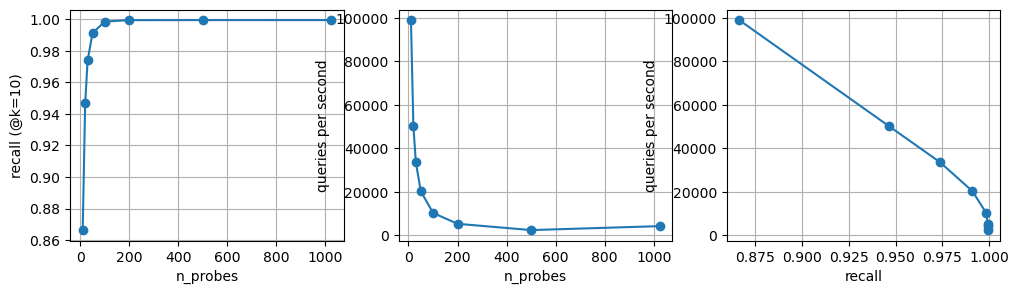

In [13]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax.plot(n_probes, recall,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('recall (@k=10)')

ax = fig.add_subplot(132)
ax.plot(n_probes, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('n_probes')
ax.grid()
ax.set_ylabel('queries per second');

ax = fig.add_subplot(133)
ax.plot(recall, qps,'o-')
#ax.set_xticks(bench_k, bench_k)
ax.set_xlabel('recall')
ax.grid()
ax.set_ylabel('queries per second');
#ax.set_yscale('log')

## Adjust build parameters
### n_lists
The number of clusters (or lists) is set by the n_list parameter. Let's change it to 100 clusters.

In [14]:
%%time
build_params = ivf_flat.IndexParams(
        n_lists=100,
        metric="euclidean",
        kmeans_trainset_fraction=1,
        kmeans_n_iters=20,
        add_data_on_build=True
    )

index = ivf_flat.build(build_params, dataset, handle=handle)

CPU times: user 640 ms, sys: 7.91 ms, total: 647 ms
Wall time: 643 ms


The ratio of n_probes / n_list will determine how large fraction of the dataset is searched for each query. The right combination depends on the use case. Here we will search 10 of the clusters for each query.

In [15]:
%%time
n_queries=10000

search_params = ivf_flat.SearchParams(n_probes=10)

# Search 10 nearest neighbors.
distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)

CPU times: user 601 ms, sys: 389 ms, total: 990 ms
Wall time: 986 ms


In [16]:
calc_recall(neighbors, gt_neighbors)

0.9876

### trainset_fraction
During clustering we can sub-sample the dataset. The parameter `trainset_fraction` determines what fraction to use. Often we get good results by using only 1/10th of the dataset for clustering. 

In [17]:
%%time
build_params = ivf_flat.IndexParams( 
        n_lists=100, 
        metric="sqeuclidean", 
        kmeans_trainset_fraction=0.1, 
        kmeans_n_iters=20 
    ) 
index = ivf_flat.build(build_params, dataset, handle=handle)

CPU times: user 91.2 ms, sys: 0 ns, total: 91.2 ms
Wall time: 90.6 ms


We see only a minimal change in the recall

In [18]:
search_params = ivf_flat.SearchParams(n_probes=10)

distances, indices = ivf_flat.search(search_params, index, cp.asarray(queries[:n_queries,:]), k=10, handle=handle)
    
handle.sync()
distances, neighbors = cp.asnumpy(distances), cp.asnumpy(indices)
calc_recall(neighbors, gt_neighbors)

0.9876

### Add vectors on build
Currently you cannot configure how cuVS sub-samples the input. If you want to have a fine control on how the training set is selected, then create the index in two steps:
1. Define cluster centers on a training set, but do not add any vector to the index
2. Add vectors to the index (extend)

This workflow shall be familiar to FAISS users. Note that cuVS does not require adding the data in batches, internal batching is used when necessary.


In [19]:
# subsample the dataset
n_train = 10000
train_set = dataset[cp.random.choice(dataset.shape[0], n_train, replace=False),:]

# build using training set
build_params = ivf_flat.IndexParams(
        n_lists=1024,
        metric="sqeuclidean",
        kmeans_trainset_fraction=1,
        kmeans_n_iters=20,
        add_data_on_build=False
    )
index = ivf_flat.build(build_params, train_set)

print("Index before adding vectors", index)

ivf_flat.extend(index, dataset, cp.arange(dataset.shape[0], dtype=cp.int64))

print("Index after adding vectors", index)

Index before adding vectors Index(type=IVF-FLAT, metric=sqeuclidean, size=0, dim=128, n_lists=1024, adaptive_centers=False)
Index after adding vectors Index(type=IVF-FLAT, metric=sqeuclidean, size=1000000, dim=128, n_lists=1024, adaptive_centers=False)
